# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [1]:
!pwd
!ls ../

/home/jovyan/may4-challenge/ex04
ex01  ex02  ex03  ex04	hints.md  requirements.txt


In [2]:
#%pip install -I git+https://github.com/qiskit-community/may4_challenge.git@0.4.30
#VGG !git clone https://github.com/qiskit-community/may4_challenge_exercises.git ~/may4_challenge_exercises
#VGG !mkdir -p ~/may4-challenge
#VGG !cp -r ~/may4_challenge_exercises/* ~/may4-challenge

In [3]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


In [4]:
print(U)

[[-0.21338835+0.33838835j -0.14016504-0.08838835j  0.21338835-0.08838835j
   0.03661165+0.08838835j  0.08838835-0.03661165j -0.08838835-0.21338835j
  -0.08838835+0.14016504j  0.33838835+0.21338835j  0.21338835-0.08838835j
   0.03661165+0.08838835j  0.39016504+0.08838835j -0.03661165+0.16161165j
   0.16161165+0.03661165j  0.08838835-0.39016504j  0.08838835-0.03661165j
  -0.08838835-0.21338835j]
 [-0.14016504-0.08838835j -0.21338835+0.33838835j  0.03661165+0.08838835j
   0.21338835-0.08838835j -0.08838835-0.21338835j  0.08838835-0.03661165j
   0.33838835+0.21338835j -0.08838835+0.14016504j  0.03661165+0.08838835j
   0.21338835-0.08838835j -0.03661165+0.16161165j  0.39016504+0.08838835j
   0.08838835-0.39016504j  0.16161165+0.03661165j -0.08838835-0.21338835j
   0.08838835-0.03661165j]
 [ 0.21338835-0.08838835j  0.03661165+0.08838835j -0.21338835+0.33838835j
  -0.14016504-0.08838835j -0.08838835+0.14016504j  0.33838835+0.21338835j
   0.08838835-0.03661165j -0.08838835-0.21338835j  0.39016

#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [5]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

In [6]:
%matplotlib inline

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit import BasicAer, transpile

#VGG from qiskit.aqua import QuantumInstance

import math
import random
import numpy as np
from scipy.optimize import minimize, basinhopping, differential_evolution, dual_annealing, shgo, brute
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [7]:
#VGG the book solution will get you to at least 1676 cxu3 cost

from qiskit import QuantumCircuit, assemble
import qiskit.quantum_info as qi
qc = QuantumCircuit(4)
ar = QuantumRegister(4)
qc.iso(U, qc.qubits,[])
print(qc)

d = assemble(qc)
print(d)

new_QC=transpile(qc,basis_gates=['cx','u3'],optimization_level=3)
check_circuit(new_QC)
#print(new_QC)

     ┌───────────┐
q_0: ┤0          ├
     │           │
q_1: ┤1          ├
     │  Isometry │
q_2: ┤2          ├
     │           │
q_3: ┤3          ├
     └───────────┘
QASM Qobj: 5e238a01-3ac7-4adf-a8be-5c8b079b4c0d:
Config: {'memory': False,
 'memory_slots': 0,
 'n_qubits': 4,
 'parameter_binds': [],
 'shots': 1024}
Header: {}
Experiments:

QASM Experiment:
Header:
{'clbit_labels': [],
 'creg_sizes': [],
 'memory_slots': 0,
 'n_qubits': 4,
 'name': 'circuit0',
 'qreg_sizes': [['q', 4]],
 'qubit_labels': [['q', 0], ['q', 1], ['q', 2], ['q', 3]]}
Config:
{'memory_slots': 0, 'n_qubits': 4}

	Instruction: isometry
		params: [array([[-0.21338835+0.33838835j, -0.14016504-0.08838835j,
         0.21338835-0.08838835j,  0.03661165+0.08838835j,
         0.08838835-0.03661165j, -0.08838835-0.21338835j,
        -0.08838835+0.14016504j,  0.33838835+0.21338835j,
         0.21338835-0.08838835j,  0.03661165+0.08838835j,
         0.39016504+0.08838835j, -0.03661165+0.16161165j,
         0.16161165

Circuit stats:
||U-V||_2 = 1.0432847120460192e-13
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Great! Your circuit meets all the constrains.
Your score is 45. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


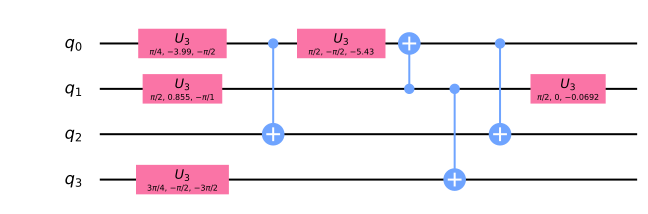

In [8]:
##### build your quantum circuit here
#qc = QuantumCircuit(4)

#VGG the quantum circuit below is due Lukasz Cincio see 1803.04114 

def create_circuit(gates):
    qc.u3(7.8539816339745e-01,-3.9949133255596e+00,-1.5707963267949e+00,gates[0])
    qc.u3(1.5707963267949e+00,8.5458825177573e-01,-3.1415926535898e+00,gates[1])
    qc.u3(2.3561944901923e+00,-1.5707963267949e+00,-4.7123889803847e+00,gates[3])
    qc.cx(0,gates[2])
    qc.u3(1.5707963267949e+00,-1.5707963267949e+00,-5.4298646352097e+00,gates[0])
    qc.cx(1,gates[0])
    qc.cx(1,gates[3])
    qc.u3(1.5707963267949e+00,-6.1785399203668e-16,-6.9190088378277e-02,gates[1])
    qc.cx(0,gates[2])
    return 

gates=[0,1,2,3]
qc = QuantumCircuit(4)
create_circuit(gates)
check_circuit(qc)
qc.draw(output='mpl')

In [9]:
#VGG finding the parameters using optimization based on the CNOT configuration

In [10]:
#VGG defining a cost function related to ||U-V||_2 by
# using the check_circuit(qc) function and context envirnoment

In [11]:
import contextlib
import sys
import io 

def foo(x):
    print(x)
    
foo("xxxx")

xxxx


In [12]:
with contextlib.redirect_stdout(io.StringIO()) as new_stdout:
    foo("yyyy")

new_stdout.seek(0)
print("data from new_stdout:",new_stdout.read())
foo("xxxx")

data from new_stdout: yyyy

xxxx


In [13]:
def cost(qc):
    with contextlib.redirect_stdout(io.StringIO()) as new_stdout:
        check_circuit(qc)

    new_stdout.seek(0)
    text=new_stdout.read()
    #print(text)

    i=text.index('=')
    j=text[i:].index('\n')
    cost=float(text[i+1:i+j])
    return cost

In [14]:
cost(qc)

1.0432847120460192e-13

In [15]:
#VGG cost function to be used in the optimization process
def calculate_cost_function(parameters):
    global qubits
    global circ

    global best_cost
    global best_parameters
    global i_call
    i_call+=1
    
    circ = QuantumCircuit(4)
    apply_fixed_ansatz(qubits, parameters)
    #check_circuit(circ)

    with contextlib.redirect_stdout(io.StringIO()) as new_stdout:
        check_circuit(circ)

    new_stdout.seek(0)
    text=new_stdout.read()
    #print("new_stdout:\n",text)

    i=text.index('=')
    j=text[i:].index('\n')
    cost=float(text[i+1:i+j])
    
    try:
        if best_cost > cost:
            best_cost = cost
            best_parameters=parameters
            #print(cost) #VGG to see the values every time the functoin is utilized 
    except:
        best_cost = cost
    
    return cost

In [ ]:
#VGG define the circuit for optimizatin 

Circuit stats:
||U-V||_2 = 0.10119675046479251
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Something is not right with your circuit: the circuit differs from the unitary more than 0.01
      ┌─────────────────┐      ┌───────────────────┐┌───┐          »
q_0: ─┤ U3(0.8,-4,-1.6) ├───■──┤ U3(1.6,-1.6,-5.4) ├┤ X ├───────■──»
     ┌┴─────────────────┴┐  │  └───────────────────┘└─┬─┘       │  »
q_1: ┤ U3(1.6,0.9,-3.14) ├──┼─────────────────────────■────■────┼──»
     └───────────────────┘┌─┴─┐                            │  ┌─┴─┐»
q_2: ─────────────────────┤ X ├────────────────────────────┼──┤ X ├»
     ┌───────────────────┐└───┘                          ┌─┴─┐└───┘»
q_3: ┤ U3(2.4,-1.6,-4.7) ├───────────────────────────────┤ X ├─────»
     └───────────────────┘                               └───┘     »
«                        
«q_0: ───────────────────
«     ┌─────────────────┐
«q_1: ┤ U3(1.6,0,-0.07) ├
«     └────────────────

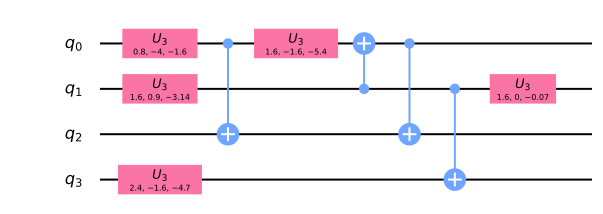

In [63]:
def apply_fixed_ansatz(gates, parameters):
#VGG this quantum circuit is due Lukasz Cincio see 1803.04114 

    global bounds
    bounds=[(-2*np.pi,2*np.pi) for i in parameters]
    
    global ranges
    ranges=bounds
    
    parameters = [parameters[3*i:3*(i+1)] for i in range(int(len(parameters)/3))]
    
    i=0
    arg=parameters[i][0:3]
    circ.u3(arg[0],arg[1],arg[2],gates[0])
    
    i+=1
    arg=parameters[i][0:3]
    circ.u3(arg[0],arg[1],arg[2],gates[1])
    
    i+=1
    arg=parameters[i][0:3]
    circ.u3(arg[0],arg[1],arg[2],gates[3])
    circ.cx(0,gates[2])
    
    i+=1
    arg=parameters[i][0:3]
    circ.u3(arg[0],arg[1],arg[2],gates[0])
    circ.cx(1,gates[0])
    circ.cx(1,gates[3])
    
    i+=1
    arg=parameters[i][0:3]
    circ.u3(arg[0],arg[1],arg[2],gates[1])
    circ.cx(0,gates[2])
    return 

circ = QuantumCircuit(4)
qubits=[0,1,2,3]
#it is good to have nice starting point - it is so hard to find it
starting_parameters=[0.8,-4,-1.6,1.6,0.9,-3.14,2.4,-1.6,-4.7, 1.6,-1.6,-5.4,1.6,0.,-0.07]

apply_fixed_ansatz(qubits,starting_parameters)
check_circuit(circ)
print(circ)

qc=circ
new_QC=transpile(qc, basis_gates=['cx','u3'],optimization_level=3)
check_circuit(new_QC)
new_QC.draw(output='mpl')

In [64]:
#VGG lets start with a random point but we can always check with the good starting point as well

best_cost=2
i_call=0
old_best=best_cost
method= 'L-BFGS-B'
out = minimize(calculate_cost_function, 
               #x0=np.random.uniform(size=15), 
               x0=starting_parameters,
               bounds=bounds, method= method, #'L-BFGS-B', 'TNC', 'SLSQP'
               #method='COBYLA',
               options={'maxiter':500}) 

success=out['success']
rate=(old_best-best_cost)/i_call*10**5
print(f'{best_cost:5.4} {rate:6.3} {i_call:8} {method:20} {success}')

1.013e-06   96.9     2064 L-BFGS-B             True


In [ ]:
#VGG now lets run few global optimizatoiuns instead 

strategy='best1bin'
old_best=cost(circ)
i_call=0
%time out=differential_evolution(calculate_cost_function,bounds=bounds,strategy=strategy)
success=out['success']
rate=(old_best-best_cost)/i_call*10**5
print(f'{best_cost:5.4} {rate:6.3} {i_call:8} {strategy:20} {success}')

In [20]:
old_best=best_cost
i_call=0
%time out=dual_annealing(calculate_cost_function,bounds=bounds, x0=best_parameters,maxiter=20)
rate=(old_best-best_cost)/i_call*10**5
success=out['success']
print(f'{best_cost:5.4} {rate:5.3} {i_call:8} dual_annealing {success}')

old_best=best_cost
i_call=0
%time out=basinhopping(calculate_cost_function, niter=2, T=1.0, stepsize=0.5, x0=best_parameters) 
rate=(old_best-best_cost)/i_call*10**5
success=out['lowest_optimization_result']['success']
print(f'{best_cost:5.4} {rate:5.3} {i_call:8} basinhopping {success}')

CPU times: user 23min 35s, sys: 8.35 s, total: 23min 43s
Wall time: 23min 44s
3.793e-07  0.761   227961 best1bin             False
CPU times: user 11.8 s, sys: 104 ms, total: 11.9 s
Wall time: 11.9 s
1.283e-07 1.43e-05     1753 dual_annealing True
CPU times: user 47.3 s, sys: 268 ms, total: 47.5 s
Wall time: 47.5 s
6.448e-08 9.02e-07     7072 basinhopping False


Circuit stats:
||U-V||_2 = 1.013128589132785e-06
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Great! Your circuit meets all the constrains.
Your score is 45. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


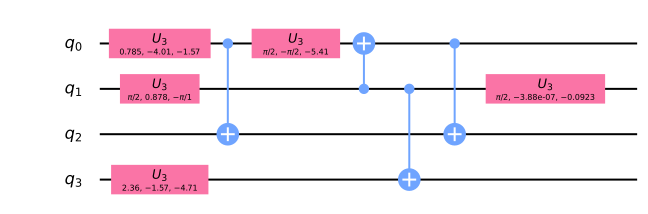

In [65]:
out_f = best_parameters

circ = QuantumCircuit(4)
apply_fixed_ansatz([0, 1, 2, 3], out_f)
check_circuit(circ)
circ.draw(output='mpl')

In [70]:
(out_f-starting_parameters).round(1)

array([-0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0., -0., -0.,
       -0., -0.])

In [23]:
# Send the circuit as the final answer, can re-submit at any time
#submit_circuit(circ) 

Circuit stats:
||U-V||_2 = 6.442717216082505e-16
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Unable to compute cost: double check your circuit is made of `u3` and `cx` gates only.

Something is not right with your circuit: the circuit contains something else than `u3` and `cx` gates


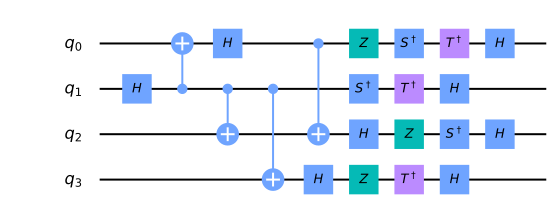

In [24]:
#VGG Adam Glos circuit

def apply_fixed_ansatz(qubits, parameters):
    
    global bounds
    bounds=[(-2*np.pi,2*np.pi) for i in parameters]
    
   #parameters = parameters[0:9]
    
    #for i in range (0, len(qubits)):
    i=0
    circ.h(qubits[i])
    circ.cx(qubits[0], qubits[1])
    circ.cx(qubits[0], qubits[2])
    circ.cx(qubits[0], qubits[3])
    
   # for i in range (0, len(qubits)):
    i=1
    circ.h(qubits[i])
    circ.cx(qubits[i], qubits[i+1])
    
    circ.z(qubits[1])
    circ.sdg(qubits[0])
    circ.h(qubits[2])
    circ.h(qubits[3])
    circ.sdg(qubits[1])
    circ.tdg(qubits[0])
    circ.z(qubits[2])
    circ.z(qubits[3])
    circ.tdg(qubits[1])
    circ.h(qubits[0])
    circ.sdg(qubits[2])
    circ.tdg(qubits[3])
    circ.h(qubits[1])
    circ.h(qubits[2])
    circ.h(qubits[3])
    
    for i in range (0, 0*len(qubits)):
        arg=parameters[i*3:(i+1)*3]
        circ.u3(arg[0],arg[1],arg[2],qubits[i])

circ = QuantumCircuit(4)
qubits=(1, 0, 2, 3)
apply_fixed_ansatz(qubits, np.pi*np.random.normal(size=12))
check_circuit(circ)
circ.draw(output='mpl')

Circuit stats:
||U-V||_2 = 1.7024872743953309e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 46

Great! Your circuit meets all the constrains.
Your score is 46. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


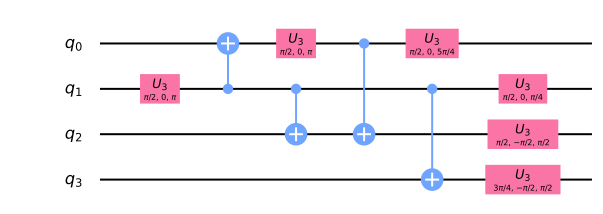

In [25]:
qc=circ
new_QC=transpile(qc, basis_gates=['cx','u3'],optimization_level=3)
check_circuit(new_QC)
new_QC.draw(output='mpl')

Circuit stats:
||U-V||_2 = 1.4330206938662507e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Unable to compute cost: double check your circuit is made of `u3` and `cx` gates only.

Something is not right with your circuit: the circuit contains something else than `u3` and `cx` gates


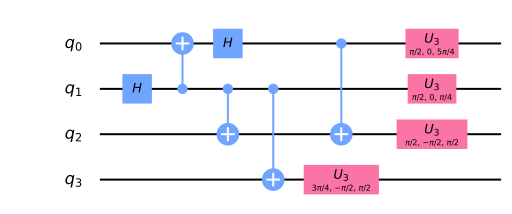

In [48]:
#VGG Adam Glos circuit
qubits= (1, 0, 2, 3)
starting_parameters=[np.pi/2,0,np.pi/4,np.pi/2,0,5*np.pi/4,np.pi/2,-np.pi/2,np.pi/2,3*np.pi/4,-np.pi/2,np.pi/2]
#starting_parameters=np.array(starting_parameters).round(1)
def apply_fixed_ansatz(qubits, parameters):
    
    global bounds
    bounds=[(-2*np.pi,2*np.pi) for i in parameters]
    
   #parameters = parameters[0:9]
    
    #for i in range (0, len(qubits)):
    i=0
    circ.h(qubits[i])
    circ.cx(qubits[0], qubits[1])
    circ.cx(qubits[0], qubits[2])
    circ.cx(qubits[0], qubits[3])
    
   # for i in range (0, len(qubits)):
    i=1
    circ.h(qubits[i])
    circ.cx(qubits[i], qubits[i+1])
    
    for i in range (0, len(qubits)):
        arg=parameters[i*3:(i+1)*3]
        circ.u3(arg[0],arg[1],arg[2],qubits[i])

circ = QuantumCircuit(4)
apply_fixed_ansatz(qubits,starting_parameters)
check_circuit(circ)
circ.draw(output='mpl')

In [52]:
parameters=np.array(starting_parameters).round(1)  #np.pi*np.random.normal(size=36)
print(parameters)
qubits= (1, 0, 2, 3)
circ = QuantumCircuit(4)
apply_fixed_ansatz(qubits,parameters)
#cost(circ)
calculate_cost_function(parameters)

[ 1.6  0.   0.8  1.6  0.   3.9  1.6 -1.6  1.6  2.4 -1.6  1.6]


0.14677184343653507

In [59]:
#VGG lets start with a random point but we can always check with the good starting point as well

best_cost=2
i_call=0
old_best=best_cost
method= 'L-BFGS-B'
out = minimize(calculate_cost_function, 
               #x0=np.random.uniform(size=12), 
               x0=parameters,
               bounds=bounds, method= method, #'L-BFGS-B', 'TNC', 'SLSQP'
               #method='COBYLA',
               options={'maxiter':500}) 

success=out['success']
rate=(old_best-best_cost)/i_call*10**5
print(f'{best_cost:5.4} {rate:6.3} {i_call:8} {method:20} {success}')

4.456e-08 1.62e+02     1235 L-BFGS-B             True


In [29]:
#VGG now lets run few global optimizatoiuns instead 

strategy='best1bin'
old_best=cost(circ)
i_call=0
%time out=differential_evolution(calculate_cost_function,bounds=bounds,strategy=strategy)
success=out['success']
rate=(old_best-best_cost)/i_call*10**5
print(f'{best_cost:5.4} {rate:6.3} {i_call:8} {strategy:20} {success}')

CPU times: user 21min 53s, sys: 5.79 s, total: 21min 59s
Wall time: 21min 59s
1.414 0.0987   182104 best1bin             False


In [58]:
old_best=best_cost
i_call=0
%time out=dual_annealing(calculate_cost_function,bounds=bounds, x0=best_parameters,maxiter=20)
rate=(old_best-best_cost)/i_call*10**5
success=out['success']
print(f'{best_cost:5.4} {rate:5.3} {i_call:8} dual_annealing {success}')

old_best=best_cost
i_call=0
%time out=basinhopping(calculate_cost_function, niter=2, T=1.0, stepsize=0.5, x0=best_parameters) 
rate=(old_best-best_cost)/i_call*10**5
success=out['lowest_optimization_result']['success']
print(f'{best_cost:5.4} {rate:5.3} {i_call:8} basinhopping {success}')

CPU times: user 12.6 s, sys: 40 ms, total: 12.7 s
Wall time: 12.7 s
1.414  18.4     3120 dual_annealing True
CPU times: user 12.2 s, sys: 92 ms, total: 12.3 s
Wall time: 12.3 s
1.414 7.24e-08     3744 basinhopping False


Circuit stats:
||U-V||_2 = 4.4560519219644954e-08
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Unable to compute cost: double check your circuit is made of `u3` and `cx` gates only.

Something is not right with your circuit: the circuit contains something else than `u3` and `cx` gates


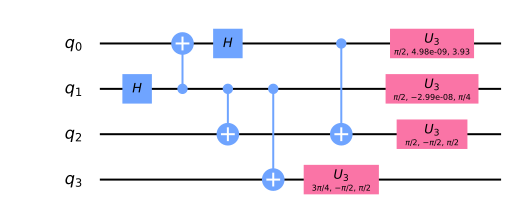

In [60]:
out_f = best_parameters

circ = QuantumCircuit(4)
apply_fixed_ansatz(qubits, out_f)
check_circuit(circ)
circ.draw(output='mpl')

Circuit stats:
||U-V||_2 = 4.456051920191742e-08
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 46

Great! Your circuit meets all the constrains.
Your score is 46. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


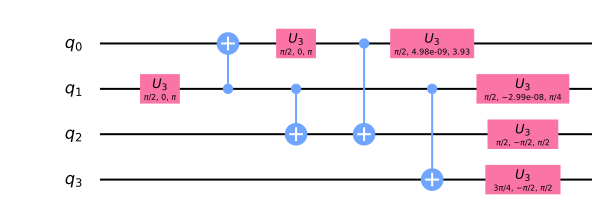

In [61]:
qc=circ
new_QC=transpile(qc, basis_gates=['cx','u3'],optimization_level=3)
check_circuit(new_QC)
new_QC.draw(output='mpl')

In [62]:
(out_f-starting_parameters).round(3)

array([ 0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.])

In [34]:
# Send the circuit as the final answer, can re-submit at any time
#submit_circuit(new_QC) 